<a href="https://colab.research.google.com/github/qugok/MIPT-Networks-Course-2021-/blob/main/hw8/Assignment_8_Graph_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment — Graph Neural Networks

In [1]:
!pip install dgl -f https://data.dgl.ai/wheels/repo.html -q

     |████████████████████████████████| 5.7 MB 6.4 MB/s 


In [2]:
import dgl
from dgl.data import CoraGraphDataset
from dgl import function as fn
from dgl.nn import GATConv, SAGEConv

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

import torch
import torch.nn as nn
import torch.nn.functional as F

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from zlib import adler32
from IPython.display import clear_output
import requests

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


### Quick introduction to PyTourch

Here is the extremely quick introduction to PyTourch. Skip this section if you are familiar with basics. Let us want to find a function that as close as possible to the sin with some noise

$$y = \sin(x) + \varepsilon$$

First, let us generate the data for training.

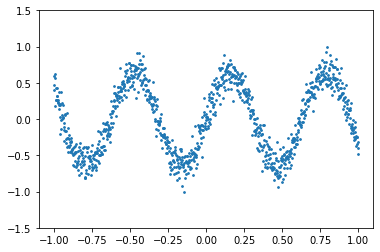

In [3]:
N = 1000
X = np.linspace(-10, 10, N)
np.random.seed(0)
y = np.sin(X) + np.random.normal(0, 0.2, N)
X = minmax_scale(X, (-1, 1))
y = minmax_scale(y, (-1, 1))
plt.scatter(X, y, s=3)
plt.ylim(-1.5, 1.5);

Next, convert np.arrays into tensors via `torch.FloatTensor` (float type) or `torch.LongTensor` (int type).

In [4]:
X_tensor = torch.FloatTensor(X[:, None])
y_tensor = torch.FloatTensor(y[:, None])

Build a model, here is a simple shallow perceptron with one-dimensional input and output so that layer sizes be $1 \to 64 \to 64 \to 1$. We get a function

$$y = f(x)$$

where $f$ is a neural net, $x$ is a given input real value, $y$ is a output real value.

In [5]:
model = nn.Sequential(nn.Linear(1, 64),
                      nn.ReLU(),
                      nn.Linear(64, 64),
                      nn.ReLU(),
                      nn.Linear(64, 1))

The loss function be mean squared error between the true dependency and approximation.

$$\text{Error} = \frac{1}{N}\sum_i^N \left(\sin(x_i) + \varepsilon - f(x_i)\right)^2$$

In [6]:
MSE = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.005)

The train loop constists of computing loss, grad, making a step to the optimum.

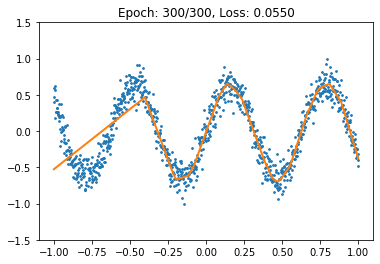

In [7]:
n_epochs = 300
for i in range(n_epochs):
    
    y_pred = model.forward(X_tensor)
    loss = MSE(y_pred, y_tensor)
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    plt.scatter(X, y, s=3)
    plt.plot(X, y_pred.detach().numpy(), linewidth=2, c='tab:orange')
    plt.title('Epoch: {}/{}, Loss: {:.4f}'.format(i+1, n_epochs, loss.item()))
    plt.ylim(-1.5, 1.5)
    plt.show()
    clear_output(wait=True)

### Task 1. Graph convolutional network (4 points)

In the task, we will train the Graph Convolutional Network (GCN) model to predict the node label (node classification task). Concretely, we will predictthe category of the paper in the citation graph. First, let us build the cora dataset.

In [8]:
dataset = CoraGraphDataset(verbose=False)
len(dataset)

Extracting file to /root/.dgl/cora_v2


1

The dataset contains one graph – CORA. Next, load the feature matrix — 0/1-valued matrix of presence 1433 words.

In [9]:
dgl_cora = dataset[0]
feat = dgl_cora.ndata['feat']
feat

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0526, 0.0000]])

And node labels (here are 7 node classes).

In [10]:
label = dgl_cora.ndata['label']
label

tensor([4, 4, 4,  ..., 4, 3, 3])

Let us create train and test boolean mask across data

In [11]:
train_mask = dgl_cora.ndata['train_mask']
test_mask = dgl_cora.ndata['test_mask']
train_mask, test_mask

(tensor([False, False, False,  ..., False, False, False]),
 tensor([ True,  True, False,  ..., False, False, False]))

Zero in-degree nodes will lead to invalid output value. This is because no message will be passed to those nodes, the aggregation function will be appied on empty input. A common practice to avoid this is to add a self-loop for each node in the graph.

In [12]:
dgl_cora = dataset[0].add_self_loop()
adj = dgl_cora.adj().to_dense()
adj

tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 1., 1.]])

Now we are ready to create the GCN [Kipf, Welling, 2016]. The next node hidden state in the graph convolution is defined as follows:

$$h_i^{l+1} = \sigma\left(b + \sum_{j\in\mathcal{N}(i)}\frac{1}{c_{ij}}h_j^{l}W\right)$$

where $\mathcal{N}(i)$ is the set of neighbors of node $i$, $c_{ij}$ is the product of the square root of node degrees (i.e.,  $c_{ij} = \sqrt{|\mathcal{N}(i)|}\sqrt{|\mathcal{N}(j)|}$), and $\sigma$ is an activation function. In the matrix form (omit bias term):

$$H^{l+1} = \sigma(D^{-1/2}AD^{-1/2}H^{l}W)$$

where $D$ is diagonal degree matrix.

Write a class `GCNLayer`. A function `init` takes an input and output dimensions (i.e. the size of matrix `W`) and store the linear layer, a function `forward` takes an adjacency matrix, node features and return node hidden states after the convolution.

*Hint:*
* *diagonal matrix can be inverted by direct inverting each element on diagonal*
* *to speed up the calculation, compute a normalized adjacency using Hadamard product instead of dot product*

In [30]:
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.dense = nn.Linear(in_dim, out_dim)

    def forward(self, adj, feat):
        # YOUR CODE HERE
        D = torch.FloatTensor(np.diag(1 / np.sqrt(adj.sum(axis=0))))
        return self.dense.forward(D @ adj @ D @ feat)


In [31]:
layer = GCNLayer(in_dim=100, out_dim=10)
with torch.no_grad():
    assert layer(adj, torch.randn(2708, 100)).shape == (2708, 10)

Write a `GCN` that represents a model for node classification among 7 classes. Let two `GCNLayer` layers with dimensions $\text{in dim} \to \text{hid dim} \to \text{out dim}$. Apply `F.relu` as an activation function after the first layer. Let us select network dimensions as `in_dim=1433`, `hid_dim=16`, `out_dim=7`.

In [32]:
class GCN(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        # YOUR CODE HERE
        # raise NotImplementedError()
        self.conv1 = GCNLayer(in_dim, hid_dim)
        self.conv2 = GCNLayer(hid_dim, out_dim)

    def forward(self, adj, feat):
        return self.conv2.forward(adj, F.relu(self.conv1.forward(adj, feat)))
        # YOUR CODE HERE
        raise NotImplementedError()

In [33]:
model = GCN(1433, 16, 7)
with torch.no_grad():
    assert model(adj, feat).shape == (2708, 7)

For classification tasks we will use `CrossEntropy` loss.

In [34]:
ce_loss = nn.CrossEntropyLoss()

Wtrite a function train that takes a model, optimizer, loss object, adjacency matrix, features, labels, and then optimize the model. It returns loss values across training and test sets.

_Hints:_
* _to speed up the calculation test loss, use `torch.no_grad()`_
* _you can detach the loss value as follows:_
```
loss = ce_loss(input, target)
value = loss.item()
```

In [35]:
def train(model, opt, loss, adj, feat, label):
    logits = model.forward(adj, feat)
    train_loss = ce_loss(logits[train_mask], label[train_mask])
    opt.zero_grad()
    train_loss.backward()
    opt.step()
    test_loss = ce_loss(logits[test_mask], label[test_mask])
    return train_loss.item(), test_loss.item()

In [36]:
model = GCN(1433, 16, 7)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
train_loss, test_loss = train(model, opt, ce_loss, adj, feat, label)
assert 1.9 < train_loss < 2
assert 1.9 < test_loss < 2

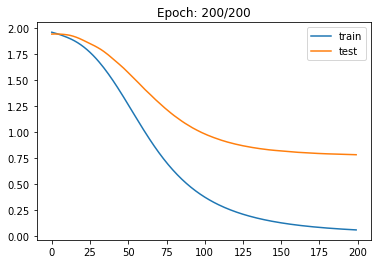

In [37]:
model = GCN(1433, 16, 7)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

n_epochs = 200
log = []
for i in range(n_epochs):
    
    train_loss, test_loss = train(model, opt, ce_loss, adj, feat, label)
    
    log.append([train_loss, test_loss])
    
    plt.plot(np.array(log))
    plt.title('Epoch: {}/{}'.format(i+1, n_epochs))
    plt.legend(['train', 'test'])
    plt.show()
    clear_output(wait=True)

In [38]:
logits = model.forward(adj, feat)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(label[test_mask], y_pred)
assert score > 0.75
print('Balanced accuracy: {:.2f}'.format(score))

Balanced accuracy: 0.78


### Task 2. Graph autoencoder (3 points)

In the previous task, we have trained our model with supervised loss in the node classification task. One can train GNN in unsupervised fashion. To do so we can state our problem as a graph autoencoder. We will train embeddings in the way to reconstruct adjacency matrix.

We will decode our adjacency matrix with `DotProductDecoder` class. A `forward` function computes dot product of node embeddings so that the result is a $n \times n$ matrix where $n$ is the number of nodes and applies the sigmoid activation


In [ ]:
class DotProductDecoder(nn.Module):
    def __init__(self, dropout_rate=None):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate else None
        self.activation = nn.Sigmoid()
    
    def forward(self, h):
        h = self.dropout(h) if self.dropout else h
        
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
decoder = DotProductDecoder()
pred_adj = decoder(torch.Tensor(np.arange(10).reshape(5, 2)))
assert round(float(pred_adj.numpy()[0, 0]), 4) == 0.7311

The class `ReconstructionLoss` computes the difference between the initial adjacency matrix and predicted adjacency matrix by cross entropy. 

`__init__` function stores the adjacency matrix of the graph as a dense tensor, and stores the positive weight as $(N^2 - E) / E$, where $N$ is a number of nodes and $E$ is a number of edges. It is important in a case of sparse graphs since we have highly imbalances classes: edges (positive class) and pairs of nodes with no edges (negative class).

`__call__` function calculates `F.binary_cross_entropy_with_logits` using positive weight `pos_weight` between the predicted adjacency matrix and real adjacency matrix.

*Hint: to obtain dense adjacency matrix, use `g.adj().to_dense()`*

In [ ]:
class ReconstructionLoss:
    def __init__(self, g):
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def __call__(self, predicted_adjacency):
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
n = dgl_cora.number_of_nodes()
pred_adj = torch.zeros(n, n)
rec_loss = ReconstructionLoss(dgl_cora)
assert round(rec_loss(pred_adj).item(), 2) == 1.38
pred_adj = torch.ones(n, n)
assert round(rec_loss(pred_adj).item(), 2) == 1.62
pred_adj = dgl_cora.adj().to_dense()
assert round(rec_loss(pred_adj).item(), 2) == 1

Let us check the quality the classification on an untrained GCN model

In [ ]:
from sklearn.linear_model import LogisticRegression
model = GCN(1433, 32, 16)
model.eval()
X = model.forward(adj, feat).data.numpy()
y = label.numpy()

lr = LogisticRegression(max_iter=1000)
lr.fit(X[train_mask], y[train_mask])

y_true = y[test_mask]
y_pred = lr.predict(X[test_mask])
score = balanced_accuracy_score(y_true, y_pred)
print('Balanced accuracy: {:.2f}'.format(score))

Complete the train loop so that node embeddings obtained from the GCN model are fed into the decoder, reconstruction loss of a predicted adjacency matrix is computed and then an optimization step is performed. You can also modify number of epochs, learning rate, etc.

In [ ]:
n_epochs = 400
model = GCN(1433, 32, 16)
decoder = DotProductDecoder(dropout_rate=0.1)
rec_loss = ReconstructionLoss(dgl_cora)
opt = torch.optim.Adam(model.parameters(), lr=0.01)

log = []
for i in range(n_epochs):
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    #train_loss = <YOUR CODE>
    log.append(train_loss)
    plt.plot(np.array(log))
    plt.title('Epoch: {}/{}'.format(i+1, n_epochs))
    plt.legend(['train'])
    plt.show()
    clear_output(wait=True)

Now we can check how unsupervised embeddings will work for the node classification task

In [ ]:
model.eval()
X = model.forward(adj, feat).data.numpy()
y = label.numpy()

lr = LogisticRegression(max_iter=1000)
lr.fit(X[train_mask], y[train_mask])

y_true = y[test_mask]
y_pred = lr.predict(X[test_mask])
score = balanced_accuracy_score(y_true, y_pred)
assert score >= 0.35
print('Balanced accuracy: {:.2f}'.format(score))

### Task 3. Graph attention network (0 points)

Let us apply Graph Attention Network over an input signal.

$$h_i^{(l+1)} = \sum_{j\in \mathcal{N}(i)} \alpha_{i,j} W^{(l)} h_j^{(l)}$$

where $\alpha_{ij}$ is the attention score bewteen node $i$ and node $j$:

$$\alpha_{ij}^{l} = \text{Softmax}_{i} (e_{ij}^{l})$$

$$e_{ij}^{l} = \text{LeakyReLU}\left(\vec{a}^T [W h_{i} \| W h_{j}]\right)$$

In [ ]:
data = CoraGraphDataset()
G = data[0]
G = dgl.add_self_loop(G)
features = G.ndata['feat']
labels = G.ndata['label']
train_mask = G.ndata['train_mask']
test_mask = G.ndata['test_mask']

Complete a class `GAT`. Use `GATConv` layers:
`GATConv(1433, 8, num_heads=8)` $\to$ `GATConv(8*8, 7, num_heads=1)`

*Hint: use `F.elu` activation*

In [ ]:
class GAT(nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        #self.conv1 = <YOUR CODE>
        #self.conv2 = <YOUR CODE>
        ### BEGIN SOLUTION
        self.conv1 = GATConv(1433, 8, 8)
        self.conv2 = GATConv(8*8, 7, 1)
        ### END SOLUTION

    def forward(self, G, features):
        ### BEGIN SOLUTION
        h = self.conv1(G, features)
        h = h.view(-1, h.size(1) * h.size(2))
        h = F.elu(h)
        h = self.conv2(G, h)
        h = h.squeeze()
        return h
        ### END SOLUTION

In [ ]:
model = GAT()
assert str(model) == 'GAT(\n  (conv1): GATConv(\n    (fc): Linear(in_features=1433, out_features=64, bias=False)\n    (feat_drop): Dropout(p=0.0, inplace=False)\n    (attn_drop): Dropout(p=0.0, inplace=False)\n    (leaky_relu): LeakyReLU(negative_slope=0.2)\n  )\n  (conv2): GATConv(\n    (fc): Linear(in_features=64, out_features=7, bias=False)\n    (feat_drop): Dropout(p=0.0, inplace=False)\n    (attn_drop): Dropout(p=0.0, inplace=False)\n    (leaky_relu): LeakyReLU(negative_slope=0.2)\n  )\n)'


In [ ]:
CrossEntropy = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), 
                       lr=0.005, weight_decay=0.0005)

Complete the train loop. To speed up calculation test loss, use `torch.no_grad()`

In [ ]:
n_epochs = 100

log = []
for i in range(n_epochs):
    
    ### BEGIN SOLUTION
    logits = model.forward(G, features)
    loss = CrossEntropy(logits[train_mask], labels[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    test_loss = CrossEntropy(logits[test_mask], labels[test_mask])
    train_loss = loss.item()
    test_loss = test_loss.item()
    ### END SOLUTION
    
    #train_loss = <YOUR CODE>
    #test_loss = <YOUR CODE>
    
    log.append([train_loss, test_loss])
    
    plt.plot(np.array(log))
    plt.title('Epoch: {}/{}'.format(i+1, n_epochs))
    plt.legend(['train', 'test'])
    plt.show()
    clear_output(wait=True)

In [ ]:
logits = model.forward(G, features)
y_pred = torch.argmax(logits[test_mask], 1)
score = balanced_accuracy_score(labels[test_mask], y_pred)
assert score > 0.7
print('Balanced accuracy: {:.2f}'.format(score))

### Task 4. GraphSAGE (3 points)

Consider GraphSAGE, a representation learning technique suitable for dynamic graphs. GraphSAGE is capable of predicting embedding of a new node, without requiring a re-training procedure. To do so, GraphSAGE learns aggregator functions that can induce the embedding of a new node given its features and neighborhood. This is called inductive learning.

$$h_{\mathcal{N}(i)}^{(l+1)} = \mathrm{aggregate}\left(\{h_{j}^{l}, \forall j \in \mathcal{N}(i) \}\right)$$
$$h_{i}^{(l+1)} = \sigma \left(W \cdot \text{concat}(h_{i}^{l}, h_{\mathcal{N}(i)}^{l+1}) \right)$$
$$h_{i}^{(l+1)} = \mathrm{norm}(h_{i}^{l})$$

Aggregator types here can be `mean`, `gcn`, `pool`, `lstm`. Consider GraphSAGE on the Karate Club graph.

In [ ]:
G = nx.karate_club_graph()

labels = [1 if i=='Mr. Hi' else 0 for i in nx.get_node_attributes(G, 'club').values()]
labels = torch.LongTensor(labels)
features = torch.FloatTensor(np.arange(0, 34)[:, None])

In [ ]:
nx.draw_kamada_kawai(
    G, with_labels=True, 
    node_color=['tab:orange' if i==1 else 'tab:blue' for i in labels], 
    cmap=plt.cm.tab10)

Let us delete the node 31, train a model and then return it and predict its label.

In [ ]:
idx = np.arange(34)
idx = idx[idx != 31]

New labels and features

In [ ]:
labels = labels[idx]
features = features[idx]

In [ ]:
nx.draw_kamada_kawai(
    G.subgraph(idx), with_labels=True, 
    node_color=['tab:orange' if i==1 else 'tab:blue' for i in labels], 
    cmap=plt.cm.tab10)

Let choose test and train nodes

In [ ]:
test_idx = [31, 32, 0, 11, 13, 2, 23, 29, 8]
train_idx = list(set(np.arange(33)).difference(test_idx))

Draw the graph, test nodes are gray.

In [ ]:
node_color = np.ones((33, 3))
node_color[labels == 0] = plt.cm.tab10(0)[:3]
node_color[labels == 1] = plt.cm.tab10(1)[:3]
node_color[test_idx] = (0.9, 0.9, 0.9)

nx.draw_kamada_kawai(G.subgraph(idx), with_labels=True, 
                     node_color=node_color, cmap=plt.cm.tab10)

Build a dgl graph 

In [ ]:
initial_graph = dgl.from_networkx(G.subgraph(idx))
initial_graph

Complete a class `SAGE`. Use `SAGEConv` layers with sizes $1 \to 16 \to 2$ and `mean` aggregation function. Put `F.relu` activation after the first layer.

In [ ]:
class SAGE(nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv1 = <YOUR CODE>
        #self.conv2 = <YOUR CODE>
        # YOUR CODE HERE
        raise NotImplementedError()

    def forward(self, graph, features):
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
model = SAGE()
assert str(model) == 'SAGE(\n  (conv1): SAGEConv(\n    (feat_drop): Dropout(p=0.0, inplace=False)\n    (fc_self): Linear(in_features=1, out_features=16, bias=False)\n    (fc_neigh): Linear(in_features=1, out_features=16, bias=False)\n  )\n  (conv2): SAGEConv(\n    (feat_drop): Dropout(p=0.0, inplace=False)\n    (fc_self): Linear(in_features=16, out_features=2, bias=False)\n    (fc_neigh): Linear(in_features=16, out_features=2, bias=False)\n  )\n)'

In [ ]:
CrossEntropy = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.002)

In [ ]:
n_epochs = 150

log = []
for i in range(n_epochs):
    
    logits = model.forward(initial_graph, features)
    loss = CrossEntropy(logits[train_idx], labels[train_idx])
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    with torch.no_grad():
        logits = model.forward(initial_graph, features)
        test_loss = CrossEntropy(logits[test_idx], labels[test_idx])
    
    log.append([loss.item(), test_loss.item()])
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(np.array(log))
    plt.title('Epoch: {}/{}'.format(i+1, n_epochs))
    plt.legend(['train', 'test'])
    
    y_pred = torch.argmax(logits, 1)
    
    plt.subplot(1, 2, 2)
    nx.draw_kamada_kawai(
        G.subgraph(idx), with_labels=True, 
        node_color=['tab:orange' if i==1 else 'tab:blue' for i in y_pred], 
        cmap=plt.cm.tab10)
    
    
    plt.show()
    clear_output(wait=True)


Let us check that prediction for the node 31 is correct

In [ ]:
graph = dgl.from_networkx(G)
labels = [1 if i=='Mr. Hi' else 0 for i in nx.get_node_attributes(G, 'club').values()]
labels = torch.LongTensor(labels)
features = torch.FloatTensor(np.arange(0, 34)[:, None])
predictions = torch.argmax(model(graph, features), 1)
assert predictions[31] == labels[31]